# cifar10 ten task

need histogram show  number of sample in each class



The MNIST dataset comes pre-loaded in Keras, in the form of a set of four Numpy arrays:

In [27]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [28]:
print(f"Training Data Shape: {train_images.shape}, Labels Shape: {train_labels.shape}")
print(f"Test Data Shape: {test_images.shape}, Labels Shape: {test_labels.shape}")

Training Data Shape: (50000, 32, 32, 3), Labels Shape: (50000, 1)
Test Data Shape: (10000, 32, 32, 3), Labels Shape: (10000, 1)


(32, 32, 3)


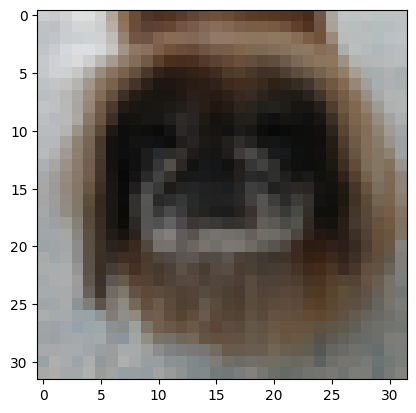

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

index = np.random.randint(len(train_images))
img = train_images[999]
print(img.shape)
plt.imshow(img)





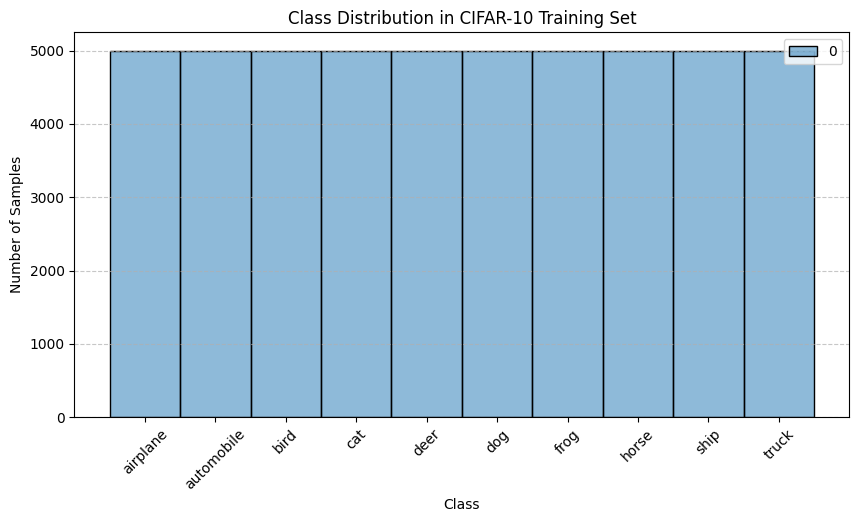

In [30]:
import numpy as np
import seaborn as sns

# Plot histogram of class distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_labels, bins=np.arange(11)-0.5, kde=False, discrete=True)
plt.xticks(ticks=range(10), labels=class_names, rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in CIFAR-10 Training Set")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [31]:
print(train_labels[0])

[6]


`train_images` and `train_labels` form the "training set", the data that the model will learn from. The model will then be tested on the
"test set", `test_images` and `test_labels`. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging
from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the training data:

In [32]:
train_images.shape

(50000, 32, 32, 3)

In [33]:
len(train_labels)

50000

In [34]:

train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [35]:
test_images.shape

(10000, 32, 32, 3)

In [36]:
len(test_labels)

10000

In [37]:
test_labels.shape

(10000, 1)

In [38]:
test_labels

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [39]:
train_images = train_images.reshape((50000, 32 * 32*3))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 32 * 32*3))
test_images = test_images.astype('float32') / 255

In [40]:
train_images.shape

(50000, 3072)

We also need to categorically encode the labels, a step which we explain in chapter 3:

In [41]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [42]:
train_labels.shape

(50000, 10)

Our workflow will be as follow: first we will present our neural network with the training data, `train_images` and `train_labels`. The
network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we
will verify if these predictions match the labels from `test_labels`.

Let's build our network -- again, remember that you aren't supposed to understand everything about this example just yet.

### Model

In [43]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(10, activation='softmax',input_shape=(32*32*3,)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
network.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 10)                  │          30,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

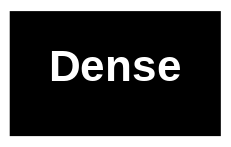

In [45]:
from keras.utils import plot_model
plot_model(network)


The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some
data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully
representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers
which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a
succession of increasingly refined data filters -- the "layers".

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers.
The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each
score will be the probability that the current digit image belongs to one of our 10 digit classes.

### Compilation: loss + optimizer

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be
able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly
classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next two chapters.

In [46]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## Loss function (objective function)
__The quantity that will be minimized during training. It represents a measure of success for the task at hand__

### Choosing the right objective function for the right problem is extremely important

your network will take any shortcut it can, to minimize the loss; so if the objective
doesn’t fully correlate with success for the task at hand, your network will end up
doing things you may not have wanted. Imagine a stupid, omnipotent AI trained via
SGD, with this poorly chosen objective function: “maximizing the average well-being
of all humans alive.” To make its job easier, this AI might choose to kill all humans
except a few and focus on the well-being of the remaining ones—because average
well-being isn’t affected by how many humans are left. That might not be what you
intended! Just remember that all neural networks you build will be just as ruthless in
lowering their loss function—so choose the objective wisely, or you’ll have to face
unintended side effects.

### Common loss functions
- __binary crossentropy__ for a _two-class_ classification problem,
- __categorical crossentropy__ for a _many-class_ classification problem,
- __mean squared error__ for a _regression problem_
- _connectionist temporal classification (__CTC__)_ for a _sequence-learning problem_

_Only when you’re working on truly new research problems will you have to develop your own objective functions_

![04_7_last_layer_activation_and_loss.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/04_7_last_layer_activation_and_loss.png?raw=true)


# We need the activation functions in the last layer to act as decision layer:

# Regression

The output can be anything.

This means linear activation.

If the output is only positive (say price), then we use relu:

![relu](https://qph.fs.quoracdn.net/main-qimg-d23ac99265ab19599e71c9d1a3cb089a)

The loss in this case is a simple MSE:

![mse](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS61PPjY7GFxPGdKiyW81wytQjWC758tQKvpYbZH-3SnM1RF6QG)

In case of 1 neuron, this is called __linear regression__

![single_neuron](https://miro.medium.com/max/913/1*rptqFUQTMiruWZWKm-WMqQ.png)

# Binary classification (logistic regression)

Output is either zero or 1
![Sigmoid](https://miro.medium.com/max/1307/1*Be3Bhz0BA-NgZIYqRVZtug.gif)

The number we get is an output of sigmoid or _logistic_ unit. That's why this model is sometimes referred to as __logistic regression__ if it's only 1 neuron. It still classification.

The output now is a __probability__ of having the 1 class. The probability of the 0 class is 1-p.

We still need a __Threshold__. Since these are probabilities, it's safe to put the threshold at 0.5:

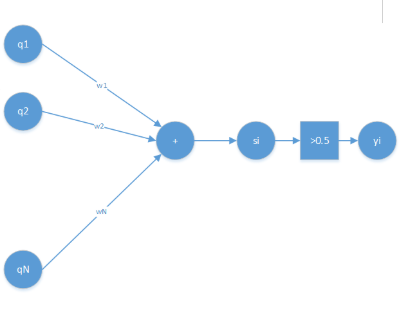

# Multi-label classification

![Multi-label](https://miro.medium.com/max/3616/1*s6Tm6f3cPhHEFdEjuCMMKQ.jpeg)

More than 1 is possible in the output

# Multi-classification

In this case, one output only is true and the rest are not. In more precise terms, we want to have probabilities output from the network, and we pick the class with highest probability.

To get those probabilities, we can normalized the outputs. We call those __normalized scores__ $f(s)_i$, which are actual probabilities

Ideally, only 1 neuron is required to be 1 and the rest are zeros. We call those targets $t_i$.

Where $0 \leq i < K$, where K is the number of classes, or sometimes called C also.

To achieve our desired output, since we take the max anyway, so we focus on the desired class neuron, __this is the probability we want maximum__. All others will depend on it then. This maximization framework is called __Cross Entropy__.


To encode that mathematically, we do the following:

$$CE = \sum_i^K{f(s)_i^{t_i}}$$

For mathematical reasons (mainly to be able to take the gradients easier as we will see later), we take the log (note that: max the log = max the original cost):

$$CE = \sum_i^K{t_i \times log f(s)_i}$$

Normally we want to maximize that cost. But since we call it __loss__ then we want to minimize a quantity, so we take __-CE__



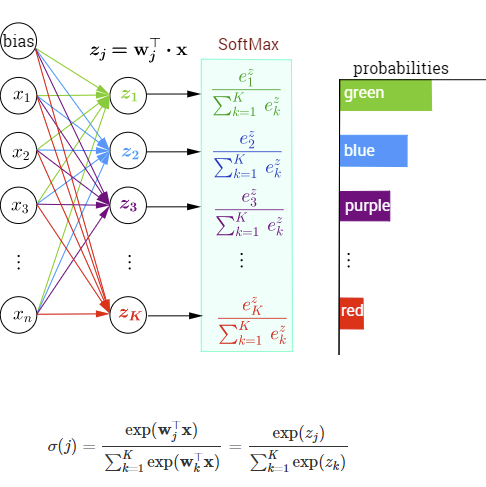

# ![BCE](https://gombru.github.io/assets/cross_entropy_loss/intro.png)

![CE](https://ztlevi.github.io/Gitbook_Machine_Learning_Questions/assets/softmax_CE_pipeline.png)

In the 2 figures above, we are usually interested in the scores $s_i$, which are the outputs at the class neurons. As you can see $log(f(s_i))$ is just $s_i$ if we neglect the denominator (common among all classes).
For this reasons $s_i$ are called _logits_. Also they represent __unnormalized probablities__, while the actual probabilitis are $f(s_i)$
In the fwd path, we just take the $argmax(s_i)$ for all class neurons.



### Learning

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network:
we "fit" the model to its training data.

In [47]:
network.fit(train_images, train_labels, epochs=25, batch_size=128)   #batch_size must be power of two to dont allaw  fregmantation

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2172 - loss: 2.3508
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3027 - loss: 2.0521
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3201 - loss: 2.0143
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3274 - loss: 1.9980
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3281 - loss: 1.9837
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3337 - loss: 1.9734
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3407 - loss: 1.9562
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3393 - loss: 1.9519
Epoch 9/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3452 - loss: 1.9507
Epoch 10/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3475 - loss: 1.9456
Epoch 11/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3438 - loss: 1.9586
Epoch 12/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over
the training data.

We quickly reach an accuracy of 0.989 (i.e. 98.9%) on the training data. Now let's check that our model performs well on the test set too:

In [48]:
test_loss, test_acc = network.evaluate(test_images, test_labels)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3381 - loss: 1.9937


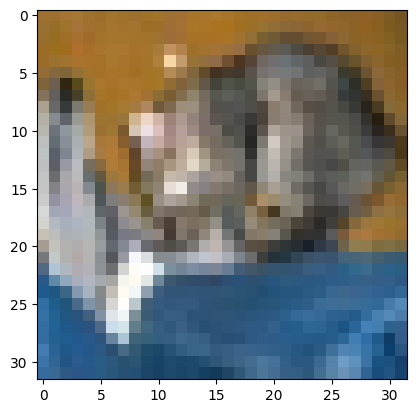

In [49]:
import matplotlib.pyplot as plt
import numpy as np

img = test_images[0]
plt.imshow(np.reshape(img, (32,32,3)))


In [50]:
img.shape

(3072,)

In [52]:
network.predict(np.reshape(img, (1,32*32*3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


array([[0.06191392, 0.12317751, 0.18591289, 0.11998493, 0.02757409,
        0.10533199, 0.07966907, 0.00103613, 0.2925847 , 0.00281481]],
      dtype=float32)

In [53]:
print(  np.argmax(network.predict(np.reshape(img, (1,32*32*3))))  )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8


In [54]:
print('test_acc:', test_acc)

test_acc: 0.3425000011920929



Our test set accuracy turns out to be 97.8% -- that's quite a bit lower than the training set accuracy.
This gap between training accuracy and test accuracy is an example of "overfitting",
the fact that machine learning models tend to perform worse on new data than on their training data.
Overfitting will be a central topic in chapter 3.

This concludes our very first example -- you just saw how we could build and a train a neural network to classify handwritten digits, in
less than 20 lines of Python code. In the next chapter, we will go in detail over every moving piece we just previewed, and clarify what is really
going on behind the scenes. You will learn about "tensors", the data-storing objects going into the network, about tensor operations, which
layers are made of, and about gradient descent, which allows our network to learn from its training examples.

On the other hand, if we can't achieve accepted performance on the trainig data, we call this __underfitting__


We control overfitting and underfitting by __model compexity__, also called __model capacity__. Usually the increased number of model parameters (for parametric models), means more model complexity:

- More layers
- More features (means more weights)
- Overtraing: handled by __early stopping__
- Higher magnitude of weights. This can be avoided by putting penalty on the magitude in the loss, called __regularization__

output = relu(dot(W, input) + b)

# data

In [55]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images = train_images.reshape((50000, 32 * 32*3))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 32 * 32*3))
test_images = test_images.astype('float32') / 255

## 2. Model

In [57]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(32*32*3,)))
network.add(layers.Dense(10, activation='softmax'))

In [58]:
network.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,578,506 (6.02 MB)

 Trainable params: 1,578,506 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Loss
## 4. Optimizer
Both under one step in Keras called compile

In [59]:
network.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [60]:
train_labels.shape

(50000, 1)

In [61]:
train_labels[0]

array([6], dtype=uint8)

Our final activation is 'softmax', and our loss is 'categorial'.

This means that, our output must be consistent with softmax output.

That format is called __One-Hot Encoding__

In [62]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
print(train_labels.shape)
print(train_labels[0])

(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [63]:
network.fit(train_images, train_labels, epochs=50, batch_size=128)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2173 - loss: 2.9098
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3447 - loss: 1.8240
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3873 - loss: 1.7253
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4087 - loss: 1.6631
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4232 - loss: 1.6285
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4349 - loss: 1.5834
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4455 - loss: 1.5689
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4535 - loss: 1.5397
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4628 - loss: 1.5086
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4689 - loss: 1.4999
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4730 - loss: 1.4853
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

# add more layer
accuresy do not  affect

In [64]:
from keras.datasets import cifar10
from keras import Model
from keras import models
from keras import layers

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.reshape((50000, 32 * 32*3))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 32*32*3))
test_images = test_images.astype('float32') / 255

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(32 * 32*3,)))
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(1024, activation='relu' ))
network.add(layers.Dense(50, activation='relu' ))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

network.fit(train_images, train_labels, epochs=50, batch_size=128)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1669 - loss: 2.3308
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3264 - loss: 1.8477
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3638 - loss: 1.7550
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3987 - loss: 1.6780
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4175 - loss: 1.6207
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4312 - loss: 1.5783
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4494 - loss: 1.5321
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4643 - loss: 1.4882
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4720 - loss: 1.4671
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4896 - loss: 1.4288
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4985 - loss: 1.3948
Epoch 12/100
391/391 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 